In [1]:
import polars as pl
import matplotlib.pyplot as plt
from event_detection_ap_score import event_detection_ap

import pandas as pd

In [2]:
# BASE_PATH = '/home/matmozaur/Downloads/child-mind-institute-detect-sleep-states/'
BASE_PATH = '../../cmidss/'

In [3]:
x_train = pl.read_parquet(BASE_PATH+'train_series.parquet')
y_train = pl.read_csv(BASE_PATH+'train_events.csv')

In [4]:
s_idxs = list(y_train['series_id'].unique())

# ----------------

In [5]:
y = y_train.filter(pl.col("series_id").is_in(s_idxs[:20])).to_pandas()

x = x_train.filter(pl.col("series_id").is_in(s_idxs[:20])).to_pandas()

In [6]:
y = y.dropna()

In [7]:
x['timestamp'] = pd.to_datetime(x['timestamp'].apply(lambda x: x[:19]))
y['timestamp'] = pd.to_datetime(y['timestamp'].apply(lambda x: x[:19]))
x.set_index('timestamp', inplace=True)
y.set_index('timestamp', inplace=True)

In [8]:
x.sort_index(inplace=True)
y.sort_index(inplace=True)

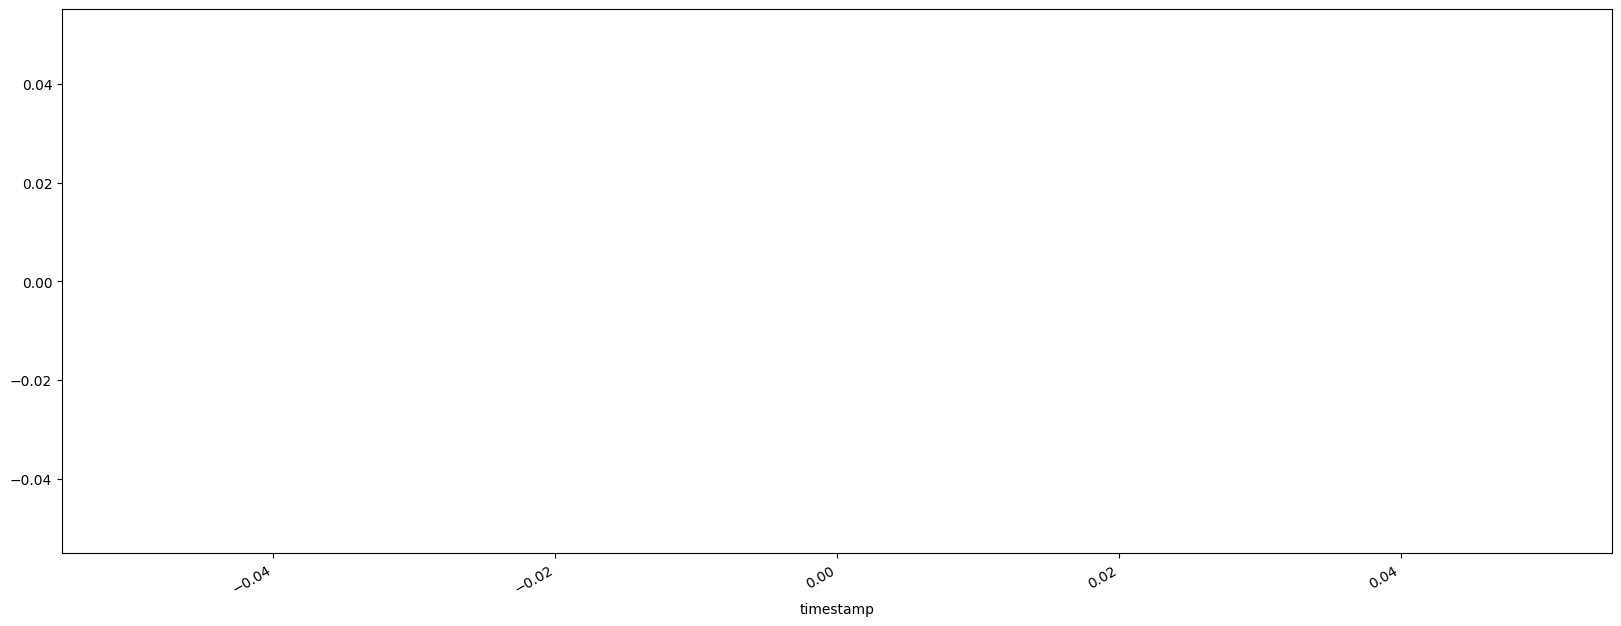

In [9]:
r = pd.to_datetime('2017-08-17 09:44:50')
s= 'ece2561f07e9'

x[x['series_id']==s]['anglez'][:r].diff().abs().rolling('15min').mean().plot(figsize=(20,8))
for a, b in zip(y[(y['event']=='onset') & (y['series_id']==s)].index,
                y[(y['event']=='wakeup') & (y['series_id']==s)].index):
    if b < r:
        plt.axvspan(a, b,alpha=0.2, color='r')

# ----------------------------

In [18]:
def fill_sleep_pred(t, fill='60min', cut='60min'):
    t = t.rolling(fill).max()
    t = t[::-1].rolling(fill).min()[::-1]

    t = t.rolling(cut).min()
    t = t[::-1].rolling(cut).max()[::-1]
    
    t = t.astype(int).diff()[2:]
    t = t[t[t==1].index[0]:]
    return t

def prepare_rows_from_sleep(t2, x, sid):
    rows = []
    last = t2.index[0] - pd.Timedelta('24h')
    i = 0 
    fail_counter = 0
    for a in t2[t2==1].index:
        if a.hour in list(range(19, 25)) + list(range(0, 3)) and a > last + pd.Timedelta('10h'):
            try:
                b = t2[a+pd.Timedelta('3h'):a+pd.Timedelta('12h')][t2[a+pd.Timedelta('3h'):a+pd.Timedelta('12h')]==-1].index[0]
                last = a
                d1 = x.loc[a][['step']].to_dict()
                i += 1
                d1['series_id'] = sid
                d1['event'] = 'onset'
                d1['score'] = 0.5
                rows.append(d1)
                d2 = x.loc[b][['step']].to_dict()
                if type(d2['step']) == dict:
                    d2['step'] = list(d2['step'].values())[0]
                i += 1
                d2['series_id'] = sid
                d2['event'] = 'wakeup'
                d2['score'] = 0.5
                rows.append(d2)
            except:
                fail_counter += 1
                continue
    print(f'Failed nights: {fail_counter}')
    return rows

def prepare_sol(x, f, fill='60min', cut='60min'):
    rows = []
    for sid in x['series_id'].unique():
        x2 = x[x['series_id'] == sid]
        t = f(x2)
        t = fill_sleep_pred(t, fill, cut)
        rows += prepare_rows_from_sleep(t, x2, sid)
    pred = pd.DataFrame.from_records(rows)
    pred.sort_values(["series_id","event"], ascending=[0,1], inplace=True)
    pred.reset_index(drop=True, inplace=True)
    pred["row_id"] = pred.index
    pred = pred[["row_id", "series_id","step","event","score"]]
    return pred

In [22]:
pred = prepare_sol(x, lambda a: a['anglez'].diff().abs().rolling('15min').mean() < 1.5)

Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 5
Failed nights: 1
Failed nights: 2
Failed nights: 0
Failed nights: 2
Failed nights: 2
Failed nights: 7
Failed nights: 0
Failed nights: 2
Failed nights: 0
Failed nights: 0
Failed nights: 1
Failed nights: 0
Failed nights: 0
Failed nights: 2


In [23]:
# t.astype(int).plot(figsize=(20,8))
# for a, b in zip(y[y['event']=='onset'].index, y[y['event']=='wakeup'].index):
#     plt.axvspan(a, b,alpha=0.2, color='r')

In [24]:
event_detection_ap(y, pred)

0.23010827210736964

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import os

# # only reads test data
# te = pd.read_parquet(BASE_PATH + 'train_series.parquet')

# # set baseline hours for sleeping and waking up
# onset = te[te["timestamp"].str.slice(11,19)=='21:37:00'].set_index("series_id")["step"]
# wakeup = te[te["timestamp"].str.slice(11,19)=='07:03:00'].set_index("series_id")["step"]

# # prep sub
# sub = pd.concat([
#     onset.reset_index().assign(event="onset"),
#     wakeup.reset_index().assign(event="wakeup"),
# ])
# sub["score"] = 0.5
# sub.sort_values(["series_id","event"], ascending=[0,1], inplace=True)
# sub.reset_index(drop=True, inplace=True)
# sub["row_id"] = sub.index
# sub = sub[["row_id", "series_id","step","event","score"]]
# sub.to_csv("submission.csv", index=False)
# sub